## Feature Engineering and CV based Winners' Solutions

Try to use MAP@7 as `feval` for xgboost, failed because no way to tell xgboost how to group results by users. **Can only do this after train is finished.**

New in this notebook:
- A hacky implementation of MAP@7 evaluation. 
- This method is suitable when training on one month and validate on another month, since ncodpers is the key in ground truth dictionaries.
- This method **only works if the MAP functions and training codes are in the same notebook**.
- The MAP values shown during training is averaged by the number of customers with new products, so very different from LB. But it gives a sense of if the algorithm is good or not.

To-do: 
- mean encoding of products grouped by combinations of: canal_entrada, segmento, cod_prov
- Time since change and lags for a few non-product features: 
    - segmento
    - ind_actividad_cliente
    - cod_prov
    - canal_entrada
    - indrel_1mes
    - tiprel_1mes


Features:
- before eda_4_29
    - average of products for each (customer, product) pair
    - exponent weighted average of products each (customer, product) pair
    - time since presence of products, distance to the first 1
    - time to the last positive flank (01)
    - time to the last negative flank (10)
    - time to the last 1, to the nearest product purchase
    - time to the first 1, to the first product purchase
    - Trained@2015-06-28, validated@2015-12-28, mlogloss=1.28481
    - Private score: 0.0302054, public score: 0.0298683
- before eda_4_25
    - customer info in the second month
    - products in the first month
    - combination of first and second month `ind_actividad_cliente`
    - combination of first and second month `tiprel_1mes`
    - combination of first month product by using binary number (`target_combine`)
    - encoding `target_combine` with 
        - mean number of new products
        - mean number of customers with new products
        - mean number of customers with each new products
    - Count patterns in the last `max_lag` months
    - Number of month to the last time the customer purchase each product
        - CV@2015-12-28: mlogloss=1.29349
        - Private score: 0.0302475, public score: 0.0299266
- eda_4_25
    - Use all available history data
        - E.g., for 2016-05-28 train data, use all previous months, for 2015-02-28, use 1 lag month. 
        - Need to create test set that use the same amount of previous months for each training data set. 
        - This is from [the second winner's solution](https://www.kaggle.com/c/santander-product-recommendation/discussion/26824), his bold part in paragraph 4.
    - Combine models trained on 2016-05-28 and 2015-06-28:
        - Private score: 0.0304583, public score: 0.0300839
        - This is to catch both seasonality and trend, presented in 2015-06-28 and 2016-05-28, respectively. 
        - This idea is mentioned by many winners, like [11-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823) and [14-th winner](https://www.kaggle.com/c/santander-product-recommendation/discussion/26808)

- eda_4_27
    - put 2015-06-28 and 2016-05-28 in the same data set, with the same lag=5
        - Private score:0.0303096, public score: 0.0299867
        - Different as [11-th winner's discussion](https://www.kaggle.com/c/santander-product-recommendation/discussion/26823)
            > We tested this by adding 50% of May-16 data to our June model and sure enough, we went from 0.0301 to 0.0303. Then, we built separate models for Jun and May, but the ensemble didn’t work. We weren’t surprised because June data is better for seasonal products, and May data is better for trend products. And vice-versa, June data is bad for trend products and May data is bad for seasonal products. So, they sort of cancelled each other out.

        - But my score is always worse than theirs, maybe this is the reason why we have different observations

# Compare two weights

In [1]:
from santander_helper import *

In [ ]:
param = {'objective': 'multi:softprob', 
         'eta': 0.05, 
         'max_depth': 8, 
         'silent': 1, 
         'num_class': len(target_cols),
         'eval_metric': 'mlogloss',
         'min_child_weight': 1,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'seed': 0,
         'booster': 'gbtree', 
         'rate_drop': 0.1, 
         'skip_drop': 0.5,
         'normalize_type': 'tree', 
         'sample_type': 'uniform'}
num_rounds = 150
month_train = '2015-06-28'
month_val = '2016-05-28'
weights = (1, 0)

history, model_dict = cv_month(param, num_rounds, month_train, month_val, n_repeat=7, random_seed=240,
                    lag_train=5, lag_val=5, weight_set=weights, verbose_eval=True)

Start weight index 1
##################################################
Train with weight 1, repetition 0 of 7
[0]	train-mlogloss:2.67691	val-mlogloss:2.70684	train-MAP@7:0.884871	val-MAP@7:0.843162
[1]	train-mlogloss:2.48684	val-mlogloss:2.53621	train-MAP@7:0.890426	val-MAP@7:0.850233
[2]	train-mlogloss:2.33764	val-mlogloss:2.40168	train-MAP@7:0.892367	val-MAP@7:0.853724
[3]	train-mlogloss:2.21417	val-mlogloss:2.29761	train-MAP@7:0.893617	val-MAP@7:0.85311
[4]	train-mlogloss:2.10896	val-mlogloss:2.20607	train-MAP@7:0.894705	val-MAP@7:0.852683
[5]	train-mlogloss:2.01729	val-mlogloss:2.12505	train-MAP@7:0.895414	val-MAP@7:0.853481
[6]	train-mlogloss:1.93567	val-mlogloss:2.0558	train-MAP@7:0.89582	val-MAP@7:0.852719
[7]	train-mlogloss:1.86267	val-mlogloss:1.99512	train-MAP@7:0.896636	val-MAP@7:0.852321
[8]	train-mlogloss:1.79646	val-mlogloss:1.94099	train-MAP@7:0.897042	val-MAP@7:0.851868
[9]	train-mlogloss:1.73609	val-mlogloss:1.8899	train-MAP@7:0.897643	val-MAP@7:0.852454
[10]	train-ml

[91]	train-mlogloss:0.710938	val-mlogloss:1.05936	train-MAP@7:0.918543	val-MAP@7:0.857284
[92]	train-mlogloss:0.70887	val-mlogloss:1.05842	train-MAP@7:0.918546	val-MAP@7:0.857128
[93]	train-mlogloss:0.706637	val-mlogloss:1.05713	train-MAP@7:0.918782	val-MAP@7:0.857143
[94]	train-mlogloss:0.704662	val-mlogloss:1.05629	train-MAP@7:0.918845	val-MAP@7:0.857043
[95]	train-mlogloss:0.702653	val-mlogloss:1.05486	train-MAP@7:0.919092	val-MAP@7:0.857157
[96]	train-mlogloss:0.700626	val-mlogloss:1.05387	train-MAP@7:0.919393	val-MAP@7:0.85701
[97]	train-mlogloss:0.698571	val-mlogloss:1.05282	train-MAP@7:0.919534	val-MAP@7:0.856859
[98]	train-mlogloss:0.696693	val-mlogloss:1.05163	train-MAP@7:0.919635	val-MAP@7:0.856845
[99]	train-mlogloss:0.694825	val-mlogloss:1.05017	train-MAP@7:0.919956	val-MAP@7:0.85694
[100]	train-mlogloss:0.692984	val-mlogloss:1.04915	train-MAP@7:0.920049	val-MAP@7:0.856942
[101]	train-mlogloss:0.691239	val-mlogloss:1.04808	train-MAP@7:0.920228	val-MAP@7:0.857078
[102]	train

[31]	train-mlogloss:1.07195	val-mlogloss:1.33708	train-MAP@7:0.906542	val-MAP@7:0.856672
[32]	train-mlogloss:1.05663	val-mlogloss:1.32431	train-MAP@7:0.906839	val-MAP@7:0.856783
[33]	train-mlogloss:1.0421	val-mlogloss:1.31329	train-MAP@7:0.907144	val-MAP@7:0.856887
[34]	train-mlogloss:1.02824	val-mlogloss:1.30358	train-MAP@7:0.907313	val-MAP@7:0.856648
[35]	train-mlogloss:1.01494	val-mlogloss:1.29259	train-MAP@7:0.907561	val-MAP@7:0.856724
[36]	train-mlogloss:1.0022	val-mlogloss:1.28265	train-MAP@7:0.907982	val-MAP@7:0.856684
[37]	train-mlogloss:0.990108	val-mlogloss:1.27236	train-MAP@7:0.908292	val-MAP@7:0.856831
[38]	train-mlogloss:0.978448	val-mlogloss:1.26217	train-MAP@7:0.908463	val-MAP@7:0.856868
[39]	train-mlogloss:0.967284	val-mlogloss:1.25285	train-MAP@7:0.908705	val-MAP@7:0.856982
[40]	train-mlogloss:0.956735	val-mlogloss:1.24359	train-MAP@7:0.909061	val-MAP@7:0.857236
[41]	train-mlogloss:0.946601	val-mlogloss:1.23477	train-MAP@7:0.909195	val-MAP@7:0.857106
[42]	train-mloglos

[123]	train-mlogloss:0.659411	val-mlogloss:1.03055	train-MAP@7:0.923515	val-MAP@7:0.856959
[124]	train-mlogloss:0.658184	val-mlogloss:1.03061	train-MAP@7:0.923742	val-MAP@7:0.856887
[125]	train-mlogloss:0.656739	val-mlogloss:1.0304	train-MAP@7:0.923908	val-MAP@7:0.856712
[126]	train-mlogloss:0.655464	val-mlogloss:1.03066	train-MAP@7:0.924257	val-MAP@7:0.856559
[127]	train-mlogloss:0.654256	val-mlogloss:1.03003	train-MAP@7:0.924262	val-MAP@7:0.856593
[128]	train-mlogloss:0.653233	val-mlogloss:1.02957	train-MAP@7:0.924287	val-MAP@7:0.856615
[129]	train-mlogloss:0.652107	val-mlogloss:1.02949	train-MAP@7:0.924452	val-MAP@7:0.856443
[130]	train-mlogloss:0.651059	val-mlogloss:1.02895	train-MAP@7:0.924594	val-MAP@7:0.856478
[131]	train-mlogloss:0.649941	val-mlogloss:1.02825	train-MAP@7:0.924712	val-MAP@7:0.856717
[132]	train-mlogloss:0.648797	val-mlogloss:1.02819	train-MAP@7:0.924923	val-MAP@7:0.85658
[133]	train-mlogloss:0.647824	val-mlogloss:1.02814	train-MAP@7:0.925062	val-MAP@7:0.856528
[

[63]	train-mlogloss:0.79893	val-mlogloss:1.1277	train-MAP@7:0.913426	val-MAP@7:0.857378
[64]	train-mlogloss:0.794489	val-mlogloss:1.12389	train-MAP@7:0.913656	val-MAP@7:0.857458
[65]	train-mlogloss:0.790353	val-mlogloss:1.12019	train-MAP@7:0.913896	val-MAP@7:0.857341
[66]	train-mlogloss:0.786134	val-mlogloss:1.11639	train-MAP@7:0.914093	val-MAP@7:0.857391
[67]	train-mlogloss:0.782149	val-mlogloss:1.11342	train-MAP@7:0.914188	val-MAP@7:0.857424
[68]	train-mlogloss:0.778242	val-mlogloss:1.11017	train-MAP@7:0.914364	val-MAP@7:0.857873
[69]	train-mlogloss:0.774547	val-mlogloss:1.10688	train-MAP@7:0.914493	val-MAP@7:0.858099
[70]	train-mlogloss:0.770868	val-mlogloss:1.10478	train-MAP@7:0.914739	val-MAP@7:0.858016
[71]	train-mlogloss:0.767418	val-mlogloss:1.10175	train-MAP@7:0.914725	val-MAP@7:0.858018
[72]	train-mlogloss:0.764003	val-mlogloss:1.09857	train-MAP@7:0.914841	val-MAP@7:0.858172
[73]	train-mlogloss:0.760382	val-mlogloss:1.0959	train-MAP@7:0.915086	val-MAP@7:0.858297
[74]	train-ml

[3]	train-mlogloss:2.21443	val-mlogloss:2.29835	train-MAP@7:0.893223	val-MAP@7:0.846766
[4]	train-mlogloss:2.10909	val-mlogloss:2.20542	train-MAP@7:0.8941	val-MAP@7:0.848391
[5]	train-mlogloss:2.01706	val-mlogloss:2.12792	train-MAP@7:0.894723	val-MAP@7:0.849108
[6]	train-mlogloss:1.93554	val-mlogloss:2.06189	train-MAP@7:0.89535	val-MAP@7:0.8501
[7]	train-mlogloss:1.86213	val-mlogloss:1.99955	train-MAP@7:0.896123	val-MAP@7:0.851429
[8]	train-mlogloss:1.79597	val-mlogloss:1.94285	train-MAP@7:0.896735	val-MAP@7:0.85214
[9]	train-mlogloss:1.7357	val-mlogloss:1.89025	train-MAP@7:0.897027	val-MAP@7:0.852014
[10]	train-mlogloss:1.68032	val-mlogloss:1.84586	train-MAP@7:0.89766	val-MAP@7:0.852001
[11]	train-mlogloss:1.62914	val-mlogloss:1.80474	train-MAP@7:0.898251	val-MAP@7:0.85252
[12]	train-mlogloss:1.58176	val-mlogloss:1.76546	train-MAP@7:0.898944	val-MAP@7:0.852553
[13]	train-mlogloss:1.53797	val-mlogloss:1.72998	train-MAP@7:0.899134	val-MAP@7:0.852843
[14]	train-mlogloss:1.49712	val-mlogl

[95]	train-mlogloss:0.703378	val-mlogloss:1.05509	train-MAP@7:0.918876	val-MAP@7:0.856655
[96]	train-mlogloss:0.701304	val-mlogloss:1.05402	train-MAP@7:0.919132	val-MAP@7:0.856376
[97]	train-mlogloss:0.699381	val-mlogloss:1.05337	train-MAP@7:0.919369	val-MAP@7:0.856301
[98]	train-mlogloss:0.697526	val-mlogloss:1.05188	train-MAP@7:0.919454	val-MAP@7:0.856351
[99]	train-mlogloss:0.695782	val-mlogloss:1.05062	train-MAP@7:0.919599	val-MAP@7:0.856416
[100]	train-mlogloss:0.693916	val-mlogloss:1.04965	train-MAP@7:0.919725	val-MAP@7:0.856345
[101]	train-mlogloss:0.692011	val-mlogloss:1.04858	train-MAP@7:0.919941	val-MAP@7:0.856355
[102]	train-mlogloss:0.690207	val-mlogloss:1.04762	train-MAP@7:0.920155	val-MAP@7:0.856303
[103]	train-mlogloss:0.688456	val-mlogloss:1.04633	train-MAP@7:0.920218	val-MAP@7:0.856224
[104]	train-mlogloss:0.68691	val-mlogloss:1.04551	train-MAP@7:0.920422	val-MAP@7:0.856216
[105]	train-mlogloss:0.685278	val-mlogloss:1.04493	train-MAP@7:0.920482	val-MAP@7:0.856344
[106]

[35]	train-mlogloss:1.01524	val-mlogloss:1.2994	train-MAP@7:0.907741	val-MAP@7:0.855365
[36]	train-mlogloss:1.00241	val-mlogloss:1.28929	train-MAP@7:0.908033	val-MAP@7:0.855242
[37]	train-mlogloss:0.990127	val-mlogloss:1.28032	train-MAP@7:0.908258	val-MAP@7:0.855517
[38]	train-mlogloss:0.97864	val-mlogloss:1.26955	train-MAP@7:0.908396	val-MAP@7:0.856218
[39]	train-mlogloss:0.96748	val-mlogloss:1.26039	train-MAP@7:0.908609	val-MAP@7:0.856245
[40]	train-mlogloss:0.956894	val-mlogloss:1.25251	train-MAP@7:0.908802	val-MAP@7:0.856367
[41]	train-mlogloss:0.946669	val-mlogloss:1.24377	train-MAP@7:0.909083	val-MAP@7:0.856398
[42]	train-mlogloss:0.936822	val-mlogloss:1.23544	train-MAP@7:0.90933	val-MAP@7:0.856651
[43]	train-mlogloss:0.927418	val-mlogloss:1.22788	train-MAP@7:0.909469	val-MAP@7:0.856623
[44]	train-mlogloss:0.918367	val-mlogloss:1.22153	train-MAP@7:0.909687	val-MAP@7:0.856513
[45]	train-mlogloss:0.909744	val-mlogloss:1.21495	train-MAP@7:0.909795	val-MAP@7:0.856188
[46]	train-mlogl

[127]	train-mlogloss:0.654696	val-mlogloss:1.03825	train-MAP@7:0.923781	val-MAP@7:0.855135
[128]	train-mlogloss:0.653492	val-mlogloss:1.03783	train-MAP@7:0.923945	val-MAP@7:0.855104
[129]	train-mlogloss:0.652355	val-mlogloss:1.03726	train-MAP@7:0.924153	val-MAP@7:0.855215
[130]	train-mlogloss:0.65125	val-mlogloss:1.03683	train-MAP@7:0.924284	val-MAP@7:0.855236
[131]	train-mlogloss:0.650022	val-mlogloss:1.03669	train-MAP@7:0.92448	val-MAP@7:0.855203
[132]	train-mlogloss:0.648892	val-mlogloss:1.03644	train-MAP@7:0.924616	val-MAP@7:0.855167
[133]	train-mlogloss:0.647824	val-mlogloss:1.03631	train-MAP@7:0.924788	val-MAP@7:0.855087
[134]	train-mlogloss:0.64667	val-mlogloss:1.0359	train-MAP@7:0.925003	val-MAP@7:0.855135
[135]	train-mlogloss:0.645529	val-mlogloss:1.0353	train-MAP@7:0.925062	val-MAP@7:0.855093
[136]	train-mlogloss:0.644716	val-mlogloss:1.03494	train-MAP@7:0.925156	val-MAP@7:0.855027
[137]	train-mlogloss:0.643663	val-mlogloss:1.03473	train-MAP@7:0.925347	val-MAP@7:0.855046
[138

[67]	train-mlogloss:0.781065	val-mlogloss:1.11115	train-MAP@7:0.914785	val-MAP@7:0.856198
[68]	train-mlogloss:0.777254	val-mlogloss:1.10819	train-MAP@7:0.914854	val-MAP@7:0.856307
[69]	train-mlogloss:0.773512	val-mlogloss:1.10554	train-MAP@7:0.914906	val-MAP@7:0.856519
[70]	train-mlogloss:0.769862	val-mlogloss:1.10247	train-MAP@7:0.915098	val-MAP@7:0.856598
[71]	train-mlogloss:0.766292	val-mlogloss:1.09964	train-MAP@7:0.915351	val-MAP@7:0.856676
[72]	train-mlogloss:0.762995	val-mlogloss:1.09701	train-MAP@7:0.915555	val-MAP@7:0.85645
[73]	train-mlogloss:0.759601	val-mlogloss:1.09401	train-MAP@7:0.915655	val-MAP@7:0.856945
[74]	train-mlogloss:0.756258	val-mlogloss:1.09159	train-MAP@7:0.915969	val-MAP@7:0.85689
[75]	train-mlogloss:0.75312	val-mlogloss:1.08916	train-MAP@7:0.916051	val-MAP@7:0.856908
[76]	train-mlogloss:0.749954	val-mlogloss:1.08641	train-MAP@7:0.916193	val-MAP@7:0.857119
[77]	train-mlogloss:0.746906	val-mlogloss:1.08463	train-MAP@7:0.916338	val-MAP@7:0.856911
[78]	train-ml

[7]	train-mlogloss:1.86122	val-mlogloss:2.00835	train-MAP@7:0.896849	val-MAP@7:0.849251
[8]	train-mlogloss:1.79518	val-mlogloss:1.95194	train-MAP@7:0.897389	val-MAP@7:0.849546
[9]	train-mlogloss:1.73472	val-mlogloss:1.90127	train-MAP@7:0.897981	val-MAP@7:0.849542
[10]	train-mlogloss:1.67944	val-mlogloss:1.85506	train-MAP@7:0.898623	val-MAP@7:0.850205
[11]	train-mlogloss:1.62896	val-mlogloss:1.81226	train-MAP@7:0.899227	val-MAP@7:0.85076
[12]	train-mlogloss:1.58146	val-mlogloss:1.77389	train-MAP@7:0.899588	val-MAP@7:0.850792
[13]	train-mlogloss:1.5376	val-mlogloss:1.73825	train-MAP@7:0.899956	val-MAP@7:0.851264
[14]	train-mlogloss:1.49681	val-mlogloss:1.70557	train-MAP@7:0.900497	val-MAP@7:0.851343
[15]	train-mlogloss:1.45895	val-mlogloss:1.67188	train-MAP@7:0.900878	val-MAP@7:0.852413
[16]	train-mlogloss:1.42279	val-mlogloss:1.64067	train-MAP@7:0.901274	val-MAP@7:0.852426
[17]	train-mlogloss:1.3893	val-mlogloss:1.61293	train-MAP@7:0.901737	val-MAP@7:0.852376
[18]	train-mlogloss:1.35763

[99]	train-mlogloss:0.695027	val-mlogloss:1.05261	train-MAP@7:0.919812	val-MAP@7:0.855749
[100]	train-mlogloss:0.693011	val-mlogloss:1.05133	train-MAP@7:0.91994	val-MAP@7:0.855769
[101]	train-mlogloss:0.691288	val-mlogloss:1.05041	train-MAP@7:0.920111	val-MAP@7:0.855893
[102]	train-mlogloss:0.689472	val-mlogloss:1.04912	train-MAP@7:0.920336	val-MAP@7:0.855862
[103]	train-mlogloss:0.687863	val-mlogloss:1.04802	train-MAP@7:0.920542	val-MAP@7:0.855916
[104]	train-mlogloss:0.686094	val-mlogloss:1.04692	train-MAP@7:0.920805	val-MAP@7:0.855943
[105]	train-mlogloss:0.684478	val-mlogloss:1.04642	train-MAP@7:0.920935	val-MAP@7:0.855742
[106]	train-mlogloss:0.682835	val-mlogloss:1.04563	train-MAP@7:0.92111	val-MAP@7:0.855626
[107]	train-mlogloss:0.681401	val-mlogloss:1.04524	train-MAP@7:0.921304	val-MAP@7:0.855389
[108]	train-mlogloss:0.679846	val-mlogloss:1.04485	train-MAP@7:0.921417	val-MAP@7:0.855247
[109]	train-mlogloss:0.678297	val-mlogloss:1.04398	train-MAP@7:0.921675	val-MAP@7:0.855431
[1

[38]	train-mlogloss:0.927149	val-mlogloss:1.23465	train-MAP@7:0.907154	val-MAP@7:0.854433
[39]	train-mlogloss:0.915814	val-mlogloss:1.22619	train-MAP@7:0.907468	val-MAP@7:0.854403
[40]	train-mlogloss:0.905036	val-mlogloss:1.21725	train-MAP@7:0.907771	val-MAP@7:0.854484
[41]	train-mlogloss:0.894643	val-mlogloss:1.20858	train-MAP@7:0.907949	val-MAP@7:0.854632
[42]	train-mlogloss:0.884666	val-mlogloss:1.20086	train-MAP@7:0.908247	val-MAP@7:0.854773
[43]	train-mlogloss:0.875085	val-mlogloss:1.19292	train-MAP@7:0.908495	val-MAP@7:0.854641
[44]	train-mlogloss:0.866078	val-mlogloss:1.18474	train-MAP@7:0.90866	val-MAP@7:0.854689
[45]	train-mlogloss:0.857485	val-mlogloss:1.17809	train-MAP@7:0.908928	val-MAP@7:0.854683
[46]	train-mlogloss:0.849122	val-mlogloss:1.17138	train-MAP@7:0.909217	val-MAP@7:0.855071
[47]	train-mlogloss:0.840979	val-mlogloss:1.16538	train-MAP@7:0.909342	val-MAP@7:0.85514
[48]	train-mlogloss:0.833161	val-mlogloss:1.15972	train-MAP@7:0.909464	val-MAP@7:0.855258
[49]	train-m

[130]	train-mlogloss:0.599893	val-mlogloss:0.999281	train-MAP@7:0.924518	val-MAP@7:0.857469
[131]	train-mlogloss:0.598842	val-mlogloss:0.998753	train-MAP@7:0.924652	val-MAP@7:0.85743
[132]	train-mlogloss:0.597569	val-mlogloss:0.998439	train-MAP@7:0.924863	val-MAP@7:0.857542
[133]	train-mlogloss:0.59636	val-mlogloss:0.997769	train-MAP@7:0.92516	val-MAP@7:0.857632
[134]	train-mlogloss:0.595169	val-mlogloss:0.997113	train-MAP@7:0.925325	val-MAP@7:0.85781
[135]	train-mlogloss:0.594134	val-mlogloss:0.997134	train-MAP@7:0.925369	val-MAP@7:0.85759
[136]	train-mlogloss:0.593115	val-mlogloss:0.997115	train-MAP@7:0.925529	val-MAP@7:0.857458
[137]	train-mlogloss:0.592052	val-mlogloss:0.996466	train-MAP@7:0.925614	val-MAP@7:0.857601
[138]	train-mlogloss:0.590919	val-mlogloss:0.996156	train-MAP@7:0.92574	val-MAP@7:0.857477
[139]	train-mlogloss:0.589951	val-mlogloss:0.995885	train-MAP@7:0.925939	val-MAP@7:0.857562
[140]	train-mlogloss:0.588855	val-mlogloss:0.995563	train-MAP@7:0.926086	val-MAP@7:0.8

[70]	train-mlogloss:0.716569	val-mlogloss:1.08075	train-MAP@7:0.914118	val-MAP@7:0.852817
[71]	train-mlogloss:0.713235	val-mlogloss:1.07824	train-MAP@7:0.914312	val-MAP@7:0.85308
[72]	train-mlogloss:0.709746	val-mlogloss:1.07546	train-MAP@7:0.914598	val-MAP@7:0.853197
[73]	train-mlogloss:0.706389	val-mlogloss:1.07294	train-MAP@7:0.914765	val-MAP@7:0.853177
[74]	train-mlogloss:0.703194	val-mlogloss:1.07043	train-MAP@7:0.914967	val-MAP@7:0.853313
[75]	train-mlogloss:0.699991	val-mlogloss:1.06778	train-MAP@7:0.915124	val-MAP@7:0.853437
[76]	train-mlogloss:0.697063	val-mlogloss:1.06584	train-MAP@7:0.915347	val-MAP@7:0.853443
[77]	train-mlogloss:0.694171	val-mlogloss:1.0639	train-MAP@7:0.915596	val-MAP@7:0.853226
[78]	train-mlogloss:0.691138	val-mlogloss:1.06202	train-MAP@7:0.91566	val-MAP@7:0.852922
[79]	train-mlogloss:0.688338	val-mlogloss:1.06008	train-MAP@7:0.915835	val-MAP@7:0.852777
[80]	train-mlogloss:0.685585	val-mlogloss:1.05834	train-MAP@7:0.915927	val-MAP@7:0.85285
[81]	train-mlo

[10]	train-mlogloss:1.63849	val-mlogloss:1.82426	train-MAP@7:0.897484	val-MAP@7:0.849734
[11]	train-mlogloss:1.58632	val-mlogloss:1.7814	train-MAP@7:0.897828	val-MAP@7:0.849893
[12]	train-mlogloss:1.53843	val-mlogloss:1.74189	train-MAP@7:0.898232	val-MAP@7:0.850263
[13]	train-mlogloss:1.49334	val-mlogloss:1.7058	train-MAP@7:0.898973	val-MAP@7:0.850691
[14]	train-mlogloss:1.4516	val-mlogloss:1.67225	train-MAP@7:0.899624	val-MAP@7:0.850744
[15]	train-mlogloss:1.41263	val-mlogloss:1.64037	train-MAP@7:0.899921	val-MAP@7:0.851004
[16]	train-mlogloss:1.37602	val-mlogloss:1.60811	train-MAP@7:0.900569	val-MAP@7:0.851369
[17]	train-mlogloss:1.34198	val-mlogloss:1.58083	train-MAP@7:0.900913	val-MAP@7:0.85153
[18]	train-mlogloss:1.30993	val-mlogloss:1.55739	train-MAP@7:0.901472	val-MAP@7:0.851291
[19]	train-mlogloss:1.27957	val-mlogloss:1.53096	train-MAP@7:0.90182	val-MAP@7:0.851211
[20]	train-mlogloss:1.25111	val-mlogloss:1.50801	train-MAP@7:0.902187	val-MAP@7:0.851581
[21]	train-mlogloss:1.2240

[102]	train-mlogloss:0.637783	val-mlogloss:1.02853	train-MAP@7:0.919908	val-MAP@7:0.853962
[103]	train-mlogloss:0.636143	val-mlogloss:1.02767	train-MAP@7:0.920051	val-MAP@7:0.853904
[104]	train-mlogloss:0.634436	val-mlogloss:1.02712	train-MAP@7:0.920197	val-MAP@7:0.853912
[105]	train-mlogloss:0.632736	val-mlogloss:1.0267	train-MAP@7:0.920413	val-MAP@7:0.853908
[106]	train-mlogloss:0.631009	val-mlogloss:1.02574	train-MAP@7:0.920568	val-MAP@7:0.853891
[107]	train-mlogloss:0.62923	val-mlogloss:1.0247	train-MAP@7:0.92092	val-MAP@7:0.854053
[108]	train-mlogloss:0.627714	val-mlogloss:1.02384	train-MAP@7:0.921122	val-MAP@7:0.854002
[109]	train-mlogloss:0.626208	val-mlogloss:1.02274	train-MAP@7:0.92118	val-MAP@7:0.854177
[110]	train-mlogloss:0.624779	val-mlogloss:1.02275	train-MAP@7:0.921273	val-MAP@7:0.85406
[111]	train-mlogloss:0.62315	val-mlogloss:1.02204	train-MAP@7:0.921399	val-MAP@7:0.854119
[112]	train-mlogloss:0.621751	val-mlogloss:1.02186	train-MAP@7:0.921514	val-MAP@7:0.853854
[113]	

[42]	train-mlogloss:0.884246	val-mlogloss:1.20718	train-MAP@7:0.908597	val-MAP@7:0.853908
[43]	train-mlogloss:0.874773	val-mlogloss:1.19988	train-MAP@7:0.908835	val-MAP@7:0.853624
[44]	train-mlogloss:0.865775	val-mlogloss:1.19262	train-MAP@7:0.909142	val-MAP@7:0.853438
[45]	train-mlogloss:0.857147	val-mlogloss:1.18612	train-MAP@7:0.909382	val-MAP@7:0.853408
[46]	train-mlogloss:0.848794	val-mlogloss:1.17985	train-MAP@7:0.909532	val-MAP@7:0.853086
[47]	train-mlogloss:0.840723	val-mlogloss:1.17272	train-MAP@7:0.909933	val-MAP@7:0.853151
[48]	train-mlogloss:0.832908	val-mlogloss:1.16718	train-MAP@7:0.909995	val-MAP@7:0.852982
[49]	train-mlogloss:0.825459	val-mlogloss:1.16146	train-MAP@7:0.910232	val-MAP@7:0.853172
[50]	train-mlogloss:0.818274	val-mlogloss:1.15517	train-MAP@7:0.910424	val-MAP@7:0.853334
[51]	train-mlogloss:0.811453	val-mlogloss:1.15032	train-MAP@7:0.910678	val-MAP@7:0.853606
[52]	train-mlogloss:0.804867	val-mlogloss:1.1442	train-MAP@7:0.910829	val-MAP@7:0.853785
[53]	train-

[134]	train-mlogloss:0.594473	val-mlogloss:1.00271	train-MAP@7:0.925009	val-MAP@7:0.855549
[135]	train-mlogloss:0.593538	val-mlogloss:1.00273	train-MAP@7:0.92513	val-MAP@7:0.855416
[136]	train-mlogloss:0.592555	val-mlogloss:1.00251	train-MAP@7:0.925326	val-MAP@7:0.855447
[137]	train-mlogloss:0.591653	val-mlogloss:1.00248	train-MAP@7:0.925475	val-MAP@7:0.85535
[138]	train-mlogloss:0.590487	val-mlogloss:1.00226	train-MAP@7:0.92563	val-MAP@7:0.855451
[139]	train-mlogloss:0.589383	val-mlogloss:1.00193	train-MAP@7:0.92589	val-MAP@7:0.855296
[140]	train-mlogloss:0.588379	val-mlogloss:1.00201	train-MAP@7:0.926033	val-MAP@7:0.855269
[141]	train-mlogloss:0.587346	val-mlogloss:1.00179	train-MAP@7:0.926181	val-MAP@7:0.855266
[142]	train-mlogloss:0.586276	val-mlogloss:1.00195	train-MAP@7:0.92642	val-MAP@7:0.855185
[143]	train-mlogloss:0.585379	val-mlogloss:1.00162	train-MAP@7:0.926445	val-MAP@7:0.855136
[144]	train-mlogloss:0.584399	val-mlogloss:1.00137	train-MAP@7:0.926527	val-MAP@7:0.855096
[145

[75]	train-mlogloss:0.70149	val-mlogloss:1.06207	train-MAP@7:0.915062	val-MAP@7:0.857784
[76]	train-mlogloss:0.698321	val-mlogloss:1.05988	train-MAP@7:0.915208	val-MAP@7:0.857705
[77]	train-mlogloss:0.695242	val-mlogloss:1.05811	train-MAP@7:0.915364	val-MAP@7:0.857683
[78]	train-mlogloss:0.692479	val-mlogloss:1.05643	train-MAP@7:0.915486	val-MAP@7:0.857598
[79]	train-mlogloss:0.68965	val-mlogloss:1.05458	train-MAP@7:0.915691	val-MAP@7:0.85767
[80]	train-mlogloss:0.686789	val-mlogloss:1.05257	train-MAP@7:0.915841	val-MAP@7:0.857614
[81]	train-mlogloss:0.684081	val-mlogloss:1.05042	train-MAP@7:0.915936	val-MAP@7:0.857681
[82]	train-mlogloss:0.681391	val-mlogloss:1.04842	train-MAP@7:0.916226	val-MAP@7:0.857619
[83]	train-mlogloss:0.678907	val-mlogloss:1.04659	train-MAP@7:0.916358	val-MAP@7:0.857505
[84]	train-mlogloss:0.676271	val-mlogloss:1.04482	train-MAP@7:0.916517	val-MAP@7:0.85752
[85]	train-mlogloss:0.673874	val-mlogloss:1.04332	train-MAP@7:0.916704	val-MAP@7:0.857504
[86]	train-mlo

[15]	train-mlogloss:1.41326	val-mlogloss:1.63023	train-MAP@7:0.899942	val-MAP@7:0.850871
[16]	train-mlogloss:1.37702	val-mlogloss:1.6005	train-MAP@7:0.900369	val-MAP@7:0.851114
[17]	train-mlogloss:1.34268	val-mlogloss:1.57333	train-MAP@7:0.900621	val-MAP@7:0.851597
[18]	train-mlogloss:1.31029	val-mlogloss:1.54601	train-MAP@7:0.901107	val-MAP@7:0.851498
[19]	train-mlogloss:1.28017	val-mlogloss:1.5215	train-MAP@7:0.901394	val-MAP@7:0.851704
[20]	train-mlogloss:1.25146	val-mlogloss:1.49917	train-MAP@7:0.901801	val-MAP@7:0.851954
[21]	train-mlogloss:1.22443	val-mlogloss:1.47807	train-MAP@7:0.902167	val-MAP@7:0.85208
[22]	train-mlogloss:1.19884	val-mlogloss:1.45764	train-MAP@7:0.90264	val-MAP@7:0.852149
[23]	train-mlogloss:1.17469	val-mlogloss:1.43898	train-MAP@7:0.903043	val-MAP@7:0.852368
[24]	train-mlogloss:1.15175	val-mlogloss:1.41952	train-MAP@7:0.903547	val-MAP@7:0.852645
[25]	train-mlogloss:1.12998	val-mlogloss:1.40261	train-MAP@7:0.903779	val-MAP@7:0.852831
[26]	train-mlogloss:1.109

In [3]:
#history_prev = pd.read_csv('weight_cv_2_history.csv', header=[0, 1, 2, 3], index_col=0)
#history_prev.columns.set_levels(history_prev.columns.levels[0].astype(int), level=0, inplace=True) # convert string to int
#history_prev.columns.set_levels(history_prev.columns.levels[1].astype(int), level=1, inplace=True) # convert string to int
val = {}

# load previous result w=exp(1/n-1)
#val[1, 'mean'] = history_prev.xs(axis=1, level=[0, 2, 3], key=(9, 'val', 'MAP@7')).apply('mean', axis=1)
#val[1, 'std'] = history_prev.xs(axis=1, level=[0, 2, 3], key=(9, 'val', 'MAP@7')).apply('std', axis=1)

# process current results
for idx, metric in itertools.product(weights, ['mean', 'std']):
    val[(idx, metric)] = history.xs(axis=1, level=[0, 2, 3], key=(idx, 'val', 'MAP@7')).apply(metric, axis=1)

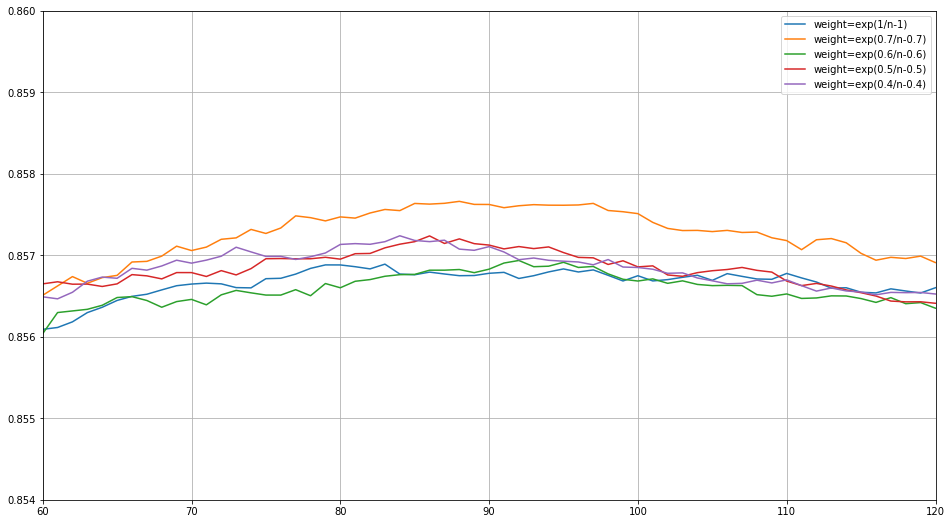

In [17]:
plt.figure(figsize=(16, 9))

#plt.plot(val[1, 'mean'], label='weight=exp(1/n-1)')
#plt.fill_between(history_prev.index, val[1, 'mean']-val[1, 'std'], val[1, 'mean']+val[1, 'std'], alpha=0.3)

nd = {1: 1, 9: 0.7, 10: 0.6, 11: 0.5, 12: 0.4, 13: 0.3, 14: 0.2, 15: 0.1}
for idx in weights[:-3]:
    plt.plot(val[idx, 'mean'], label='weight=exp({}/n-{})'.format(nd[idx], nd[idx]))
    #plt.fill_between(history.index, val[idx, 'mean']-val[idx, 'std'], val[idx, 'mean']+val[idx, 'std'], alpha=0.3)

plt.grid()
plt.xlim(60, 120)
plt.ylim(0.854, 0.86)
plt.legend()

In [5]:
history.to_csv('weight_cv_4_history.csv')

In [6]:
save_pickle('weight_cv_4_models.pickle', model_dict)